In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import sys
import glob
sys.path.append('../../../src')

from common import common, transform, json, video
from common.functions import cos_similarity, gauss
from common.json import IA_FORMAT, START_IDX, GA_FORMAT, ATTENTION_FORMAT
from common.default import PASSING_DEFAULT
from common.object_point import OBJECT_POINTS
from individual_activity.individual_activity import IndividualActivity
from display.individual_activity import disp_individual_activity
from display.tracking import disp_tracking
from display.heatmap import Heatmap

# Attention をロード

In [2]:
# group attention のデータはまだない
data_settings = [
    {'room_num': '02', 'date': '20210903', 'option': 'attention'},
    {'room_num': '08', 'date': '20210915', 'option': 'attention'},
    {'room_num': '09', 'date': '20210706', 'option': 'attention'}
]

In [3]:
attentions = {}
for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    if opt is None:
        dir_path = f'{common.data_dir}/{room_num}/{date}/*'
    else:
        dir_path = f'{common.data_dir}/{room_num}/{date}/{opt}/*'
    dirs = glob.glob(dir_path)
    if dirs[-1].endswith('make_csv.csv'):
        dirs = dirs[:-1]
    
    for i, path in enumerate(tqdm(dirs)):
        path = f'{path}/json/group_activity.json'
        json_data = json.load(path)
        key = f"{room_num}_{date}_{i + 1:02d}"
        attentions[key] = json_data["attention"]

{'room_num': '02', 'date': '20210903', 'option': 'attention'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.17s/it]


{'room_num': '08', 'date': '20210915', 'option': 'attention'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.92s/it]


{'room_num': '09', 'date': '20210706', 'option': 'attention'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.11s/it]


# 対象物のスコアを計算
https://qiita.com/masataka46/items/cb5b05090746c7f3b826

In [4]:
def likelihood(object_point, attention_data, sigma=50):
    px = object_point[0]
    py = object_point[1]
    
    value_dict = {}
    for data in tqdm(attention_data):
        frame_num = data[ATTENTION_FORMAT[0]]
        x, y = data[ATTENTION_FORMAT[2]]
        count = data[ATTENTION_FORMAT[4]]
        gauss = np.exp(-((x - px)**2 + (y - py)**2) / (2 * sigma ** 2))
        
        if frame_num not in value_dict:
            value_dict[frame_num] = {"counts": [], "weights": []}
            
        value_dict[frame_num]["counts"].append(count)
        value_dict[frame_num]["weights"].append(gauss + 1e-10)
        
    means = {}
    for frame_num, value in value_dict.items():
        means[frame_num] = np.average(value["counts"], weights=value["weights"])
    
    return means

In [5]:
likelihood_dict = {}
for key, attention_data in attentions.items():
    room_num, date, num = key.split("_")
    print(room_num, date, num)
    object_points = OBJECT_POINTS[room_num][date][num]
    for i, object_point in enumerate(object_points):
        value = likelihood(object_point, attention_data)
        new_key = f"{key}_{i + 1}"
        likelihood_dict[new_key] = value

02 20210903 01


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1860068/1860068 [00:03<00:00, 567448.80it/s]


02 20210903 02


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2240198/2240198 [00:03<00:00, 568561.41it/s]


02 20210903 03


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1449954/1449954 [00:02<00:00, 578447.63it/s]


02 20210903 04


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 917851/917851 [00:01<00:00, 544917.41it/s]


08 20210915 01


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1669592/1669592 [00:03<00:00, 539830.47it/s]


08 20210915 02


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2449839/2449839 [00:04<00:00, 575502.32it/s]


08 20210915 03


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1852165/1852165 [00:03<00:00, 563386.61it/s]


08 20210915 04


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310924/310924 [00:00<00:00, 599479.90it/s]


09 20210706 01


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1275900/1275900 [00:02<00:00, 582774.72it/s]


09 20210706 02


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2666004/2666004 [00:04<00:00, 586535.53it/s]


09 20210706 03


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1720718/1720718 [00:02<00:00, 575650.84it/s]


09 20210706 04


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1440505/1440505 [00:02<00:00, 587050.42it/s]


# 動画作成

In [6]:
def display_likelihood(object_point, value, heatmap_cls, field, max_radius=20, alpha=0.7):
    copy = field.copy()
    
    color = heatmap_cls.colormap(value)

    # calc radius of circle
    max_value = heatmap_cls.xmax
    radius = int(value / max_value * max_radius)
    if radius == 0:
        radius = 1
    # plot the heatmap circle
    cv2.circle(copy, object_point, radius, color, thickness=-1)

    # plot the center of object
    cv2.circle(copy, tuple(object_point), 3, (0, 0, 0), -1)
    
    point = np.array(object_point) - [50, 10]
    point = tuple(point)
    cv2.putText(copy, f"{value:.1f}", point, cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 2)
    
    field = cv2.addWeighted(copy, alpha, field, 1 - alpha, 0)
    
    # plt.imshow(field)
    # plt.show()

    return field

In [7]:
def combine_image(frame, field):
    ratio = 1 - (field.shape[0] - frame.shape[0]) / field.shape[0]
    size = [int(field.shape[1] * ratio), int(field.shape[0] * ratio)]
    if frame.shape[0] != size[1]:
        # 丸め誤差が起きる
        size[1] = frame.shape[0]
    field = cv2.resize(field, size)
    frame = np.concatenate([frame, field], axis=1)

    return frame


def display(
    video_path,
    out_path,
    individual_activity_json_path,
    likelihood_data,
    heatmap_cls,
    field,
    object_point,
):
    print(out_path)
    print("Writing video frames...")

    # load datas
    individual_activity_datas = json.load(individual_activity_json_path)

    # load video
    capture = video.Capture(video_path)

    # frames_lst = [[] for _ in range(len(out_paths))]
    cmb_img = combine_image(capture.read(), field)
    size = cmb_img.shape[1::-1]
    writer = video.Writer(out_path, capture.fps, size)

    # reset capture start position
    capture.set_pos_frame(0)

    for frame_num in tqdm(range(capture.frame_num)):
        # read frame
        frame = capture.read()

        # フレームごとにデータを取得する
        frame_individual_activity_datas = [
            data for data in individual_activity_datas if data["frame"] == frame_num
        ]

        # フレーム番号を表示
        cv2.putText(
            frame,
            "Frame:{}".format(frame_num + 1),
            (10, 50),
            cv2.FONT_HERSHEY_PLAIN,
            2,
            (0, 0, 0),
        )

        # copy raw field image
        field_tmp = field.copy()

        # draw tracking result
        frame = disp_tracking(frame_individual_activity_datas, frame)

        # draw individual activity
        field_tmp = disp_individual_activity(
            frame_individual_activity_datas, field_tmp
        )

        # draw likelihood
        field_tmp = display_likelihood(object_point, likelihood_data[frame_num], heatmap_cls, field_tmp)

        # write video
        writer.write(combine_image(frame, field_tmp))


def get_field(room_num):
    field_path = os.path.join(common.data_dir, room_num, 'field.png')
    return cv2.imread(field_path)

In [8]:
for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    if opt is None:
        dir_path = f'{common.data_dir}/{room_num}/{date}/*'
    else:
        dir_path = f'{common.data_dir}/{room_num}/{date}/{opt}/*'
    dirs = glob.glob(dir_path)
    if dirs[-1].endswith('make_csv.csv'):
        dirs = dirs[:-1]
        
    field = get_field(room_num)
    
    for i, path in enumerate(dirs):
        num = f"{i + 1:02d}"
        ia_json_path = os.path.join(path, 'json', 'individual_activity.json')
        video_path = os.path.join(path, 'video', f'pose_{num}.mp4')
        out_dir = os.path.join(path, 'out')
        cap = video.Capture(video_path)
        
        object_points = OBJECT_POINTS[room_num][date][num]
        for j, object_point in enumerate(object_points):
            print(object_point)
            out_path = os.path.join(out_dir, f'attention_object{j + 1}.mp4')
            key = f"{room_num}_{date}_{i + 1:02d}_{j + 1}"
            likelihood_data = likelihood_dict[key]
            max_val = np.max(list(likelihood_data.values()))
            print(max_val)
            heatmap_cls = Heatmap([0, max_val])
            display(
                video_path,
                out_path,
                ia_json_path,
                likelihood_data,
                heatmap_cls,
                field,
                object_point,
            )

{'room_num': '02', 'date': '20210903', 'option': 'attention'}
(50, 780)
1.7324492734044665
C:\Users\k2111\program\research\data/02/20210903/attention\01\out\attention_object1.mp4
Writing video frames...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:42<00:00, 42.49it/s]


(525, 625)
1.7573714559456808
C:\Users\k2111\program\research\data/02/20210903/attention\02\out\attention_object1.mp4
Writing video frames...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:39<00:00, 45.66it/s]


(367, 415)
1.2246747368184567
C:\Users\k2111\program\research\data/02/20210903/attention\03\out\attention_object1.mp4
Writing video frames...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:37<00:00, 47.72it/s]


(50, 780)
1.2886243308015541
C:\Users\k2111\program\research\data/02/20210903/attention\04\out\attention_object1.mp4
Writing video frames...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:35<00:00, 50.63it/s]


(525, 625)
1.0281971298711396
C:\Users\k2111\program\research\data/02/20210903/attention\04\out\attention_object2.mp4
Writing video frames...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:35<00:00, 50.68it/s]


(367, 415)
1.3709483699900067
C:\Users\k2111\program\research\data/02/20210903/attention\04\out\attention_object3.mp4
Writing video frames...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:35<00:00, 50.00it/s]


{'room_num': '08', 'date': '20210915', 'option': 'attention'}
(670, 120)
1.4103014369677
C:\Users\k2111\program\research\data/08/20210915/attention\01\out\attention_object1.mp4
Writing video frames...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1872/1872 [00:39<00:00, 47.87it/s]


(367, 530)
1.6751617004511374
C:\Users\k2111\program\research\data/08/20210915/attention\02\out\attention_object1.mp4
Writing video frames...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1872/1872 [00:41<00:00, 44.99it/s]


(367, 415)
1.9612147819649488
C:\Users\k2111\program\research\data/08/20210915/attention\03\out\attention_object1.mp4
Writing video frames...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1872/1872 [00:40<00:00, 45.70it/s]


(670, 120)
0.6359850636289455
C:\Users\k2111\program\research\data/08/20210915/attention\04\out\attention_object1.mp4
Writing video frames...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1872/1872 [00:35<00:00, 52.68it/s]


(365, 530)
1.1185994262755938
C:\Users\k2111\program\research\data/08/20210915/attention\04\out\attention_object2.mp4
Writing video frames...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1872/1872 [00:35<00:00, 52.39it/s]


(367, 415)
1.1166650091021928
C:\Users\k2111\program\research\data/08/20210915/attention\04\out\attention_object3.mp4
Writing video frames...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1872/1872 [00:36<00:00, 51.98it/s]


{'room_num': '09', 'date': '20210706', 'option': 'attention'}
(685, 780)
2.1784558195664507
C:\Users\k2111\program\research\data/09/20210706/attention\01\out\attention_object1.mp4
Writing video frames...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:41<00:00, 43.69it/s]


(510, 800)
2.045087913834783
C:\Users\k2111\program\research\data/09/20210706/attention\02\out\attention_object1.mp4
Writing video frames...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:41<00:00, 43.54it/s]


(367, 415)
1.8304091222854117
C:\Users\k2111\program\research\data/09/20210706/attention\03\out\attention_object1.mp4
Writing video frames...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:38<00:00, 46.96it/s]


(685, 780)
1.1656092131083338
C:\Users\k2111\program\research\data/09/20210706/attention\04\out\attention_object1.mp4
Writing video frames...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:37<00:00, 47.50it/s]


(510, 800)
1.363202807593187
C:\Users\k2111\program\research\data/09/20210706/attention\04\out\attention_object2.mp4
Writing video frames...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:38<00:00, 47.27it/s]


(367, 415)
1.4189061748668301
C:\Users\k2111\program\research\data/09/20210706/attention\04\out\attention_object3.mp4
Writing video frames...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:37<00:00, 47.72it/s]


# 修論用解析
## ヒストグラム、箱ひげ図

In [8]:
def boxplot(df_lst):
    fig = plt.figure(figsize=(5, 2))
    axs = [
        fig.add_axes((0.1, 0.1, 0.29, 0.85)),
        fig.add_axes((0.4, 0.1, 0.29, 0.85)),
        fig.add_axes((0.7, 0.1, 0.29, 0.85))
    ]

    for j in range(3):
        sns.boxplot(x='variable', y='value', data=df_lst[j], showfliers=False, ax=axs[j])
        axs[j].set_ylabel('')
        axs[j].set_xlabel('')
        axs[j].set_ylim((0, 2.5))

    axs[0].set_ylabel('Attention Score')
    axs[1].set_yticklabels([])
    axs[2].set_yticklabels([])

    box_path = os.path.join(common.data_dir, 'image', opt, f'box_{room_num}_{date}.pdf')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    fig.savefig(box_path)

In [9]:
def hist(df_lst, labels_lst):
    fig = plt.figure(figsize=(5, 2))
    axs = [
        fig.add_axes((0.06, 0.2, 0.26, 0.75)),
        fig.add_axes((0.39, 0.2, 0.26, 0.75)),
        fig.add_axes((0.72, 0.2, 0.26, 0.75))
    ]
    
    for j in range(3):
        sns.histplot(
            data=df_lst[j], x='value', hue='variable', bins=20, kde=True, ax=axs[j]
        )
        
        axs[j].set_ylabel('')
        axs[j].set_xlabel('')
        axs[j].legend(
            labels=labels_lst[j][::-1], fontsize=7, handlelength=0.5, handletextpad=0.2
        )

        axs[j].set_xlabel('Attention Score')

    box_path = os.path.join(common.data_dir, 'image', opt, f'hist_{room_num}_{date}.pdf')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    fig.savefig(box_path)

{'room_num': '02', 'date': '20210903', 'option': 'attention'}
{'room_num': '08', 'date': '20210915', 'option': 'attention'}
{'room_num': '09', 'date': '20210706', 'option': 'attention'}


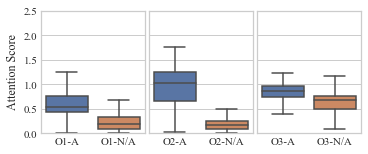

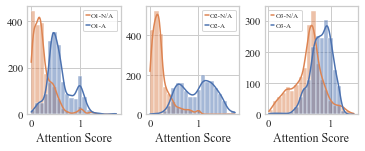

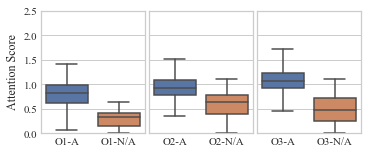

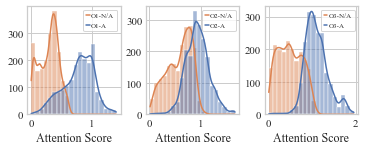

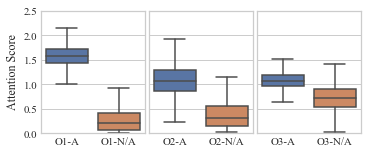

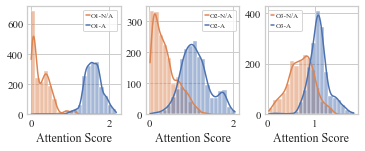

In [10]:
sns.set()
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.direction'] = 'in'  # x axis in
plt.rcParams['ytick.direction'] = 'in'  # y axis in

for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    df_lst = []
    labels_lst = []
    for i in range(3):
        data_dict = {}
        key1 = f"{room_num}_{date}_{i + 1:02d}_{1}"
        key2 = f"{room_num}_{date}_04_{i + 1}"
        data1 = list(likelihood_dict[key1].values())
        data2 = list(likelihood_dict[key2].values())
        
        label1 = f'O{i % 3 + 1}-A'
        label2 = f'O{i % 3 + 1}-N/A'
        labels = [label1, label2]
        labels_lst.append(labels)
        
        data_dict[label1] = data1
        data_dict[label2] = data2
        
        df = pd.DataFrame.from_dict(data_dict)
        df = pd.melt(df)
        df_lst.append(df)
    
    boxplot(df_lst)
    hist(df_lst, labels_lst)

## 検定

In [11]:
from scipy import stats

In [98]:
import pandas as pd

def mwu(data1, data2):
    n1, n2 = len(data1), len(data2)
    mu = n1 * n2 / 2
    sigma = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
    
    df = pd.DataFrame({
        1: data1,
        2: data2
    })
    df = pd.melt(df)
    df = pd.concat([df, df.rank()["value"]], axis=1)
    df.columns = ["label", "value", "rank"]
    print(df.head())
    print(df.tail())
    
    df[df["label"] == 1]["rank"].hist()
    plt.show()
    df[df["label"] == 2]["rank"].hist()
    plt.show()
    
    rank_sum1 = df[df["label"] == 1].sum()["rank"]
    rank_sum2 = df[df["label"] == 2].sum()["rank"]
    print('rank sum:', rank_sum1, rank_sum2)
    
    u1 = n1 * n2 + n1 * (n1 + 1) / 2 - rank_sum1
    u2 = n1 * n2 - u1
    print('u1, u2 ', u1, u2)
    
    u = u1 if u1 > mu else u2
    print('u=', u)
        
    z = (u1 - mu) / sigma
    print('z=', z)
    
    p = np.exp(- (z**2) / 2) / np.sqrt(2 * np.pi)
    print("p=", p)

{'room_num': '02', 'date': '20210903', 'option': 'attention'}
O_1
   label     value   rank
0      1  0.002810   11.0
1      1  0.006160   48.0
2      1  0.010635  113.0
3      1  0.013762  140.0
4      1  0.018301  171.0
      label     value    rank
3595      2  0.141558  1278.0
3596      2  0.055473   498.0
3597      2  0.180816  1488.0
3598      2  0.200114  1590.0
3599      2  0.220242  1706.0


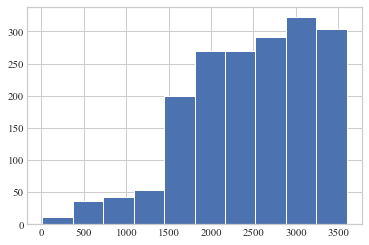

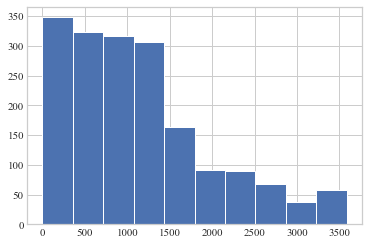

rank sum: 4442801.0 2038999.0
u1, u2  418099.0 2821901.0
u= 2821901.0
z= -38.545639360105675
p= 1e-323
O_2
   label     value   rank
0      1  0.017268  157.0
1      1  0.037770  322.0
2      1  0.039054  334.0
3      1  0.049132  426.0
4      1  0.066546  604.0
      label     value   rank
3595      2  0.010854  105.0
3596      2  0.023191  200.0
3597      2  0.004942   45.0
3598      2  0.004077   37.0
3599      2  0.031385  271.0


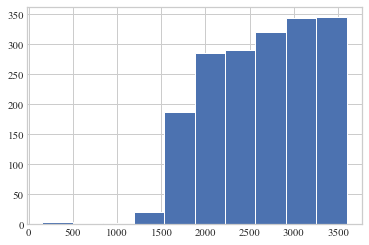

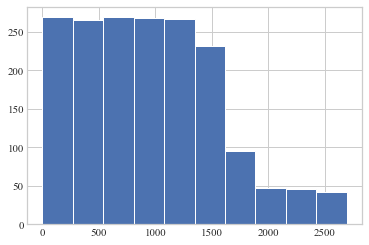

rank sum: 4767066.0 1714734.0
u1, u2  93834.0 3146166.0
u= 3146166.0
z= -48.94499982914985
p= 0.0
O_3
   label     value  rank
0      1  0.009959   2.0
1      1  0.023343   4.0
2      1  0.039384  13.0
3      1  0.054693  23.0
4      1  0.070298  37.0
      label     value    rank
3595      2  0.352135   483.0
3596      2  0.435735   810.0
3597      2  0.323298   417.0
3598      2  0.452471   897.0
3599      2  0.471877  1046.0


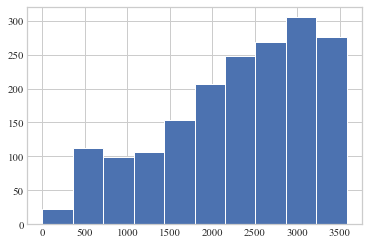

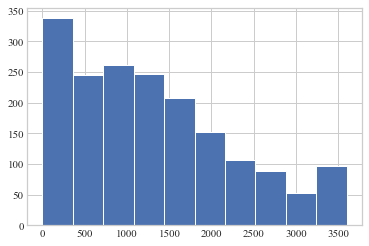

rank sum: 4117387.0 2364413.0
u1, u2  743513.0 2496487.0
u= 2496487.0
z= -28.109429816449893
p= 1.0572541882402862e-172
{'room_num': '08', 'date': '20210915', 'option': 'attention'}
O_1
   label     value   rank
0      1  0.022649  106.0
1      1  0.025470  120.0
2      1  0.032851  179.0
3      1  0.046722  263.0
4      1  0.065325  294.0
      label     value    rank
3739      2  0.397113  2182.0
3740      2  0.404337  2207.0
3741      2  0.426030  2299.0
3742      2  0.443754  2356.0
3743      2  0.450165  2365.0


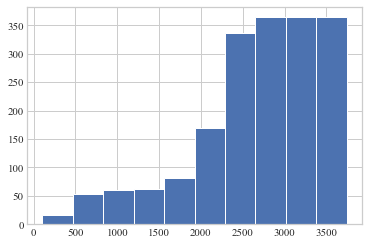

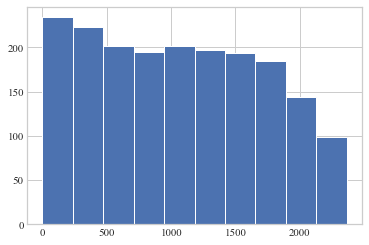

rank sum: 5018812.0 1991828.0
u1, u2  238700.0 3265684.0
u= 3265684.0
z= -45.76558280782946
p= 0.0
O_2
   label     value   rank
0      1  0.010569    3.0
1      1  0.033168   27.0
2      1  0.056242   65.0
3      1  0.076966  103.0
4      1  0.100405  153.0
      label     value    rank
3739      2  0.444115  1675.0
3740      2  0.464185  1869.0
3741      2  0.484255  2051.0
3742      2  0.504326  2250.0
3743      2  0.524395  2493.0


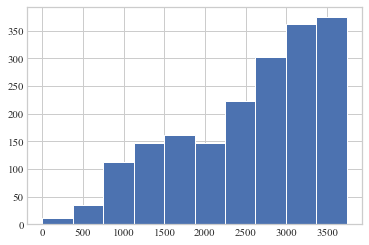

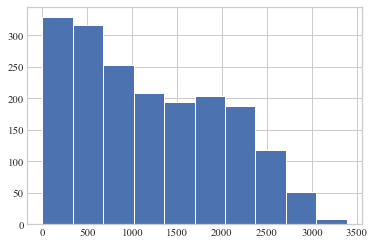

rank sum: 4777568.0 2233072.0
u1, u2  479944.0 3024440.0
u= 3024440.0
z= -38.470749231641406
p= 1.7e-322
O_3
   label     value   rank
0      1  0.016316   29.0
1      1  0.033451   76.0
2      1  0.047881  138.0
3      1  0.067805  217.0
4      1  0.088130  302.0
      label     value    rank
3739      2  0.406249  1703.0
3740      2  0.423297  1830.0
3741      2  0.440347  1978.0
3742      2  0.457396  2116.0
3743      2  0.474444  2278.0


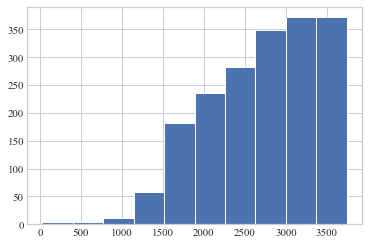

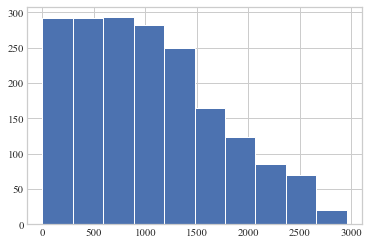

rank sum: 5078960.0 1931680.0
u1, u2  178552.0 3325832.0
u= 3325832.0
z= -47.58436234199636
p= 0.0
{'room_num': '09', 'date': '20210706', 'option': 'attention'}
O_1
   label     value   rank
0      1  0.018705  326.0
1      1  0.039716  557.0
2      1  0.060684  750.0
3      1  0.080647  868.0
4      1  0.102257  932.0
      label     value    rank
3595      2  0.217232  1505.0
3596      2  0.216597  1502.0
3597      2  0.210034  1475.0
3598      2  0.212876  1486.0
3599      2  0.218942  1513.0


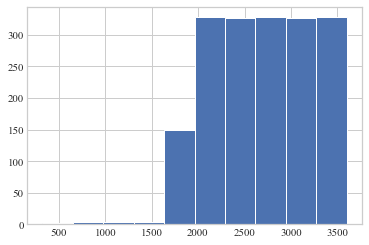

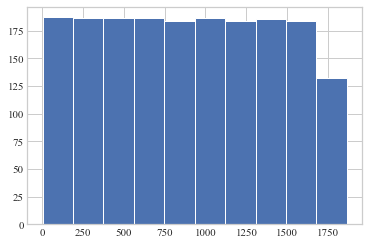

rank sum: 4850395.0 1631405.0
u1, u2  10505.0 3229495.0
u= 3229495.0
z= -51.617407608358164
p= 0.0
O_2
   label     value   rank
0      1  0.008228   34.0
1      1  0.025447  164.0
2      1  0.042980  290.0
3      1  0.064429  465.0
4      1  0.091607  627.0
      label     value    rank
3595      2  0.173671  1054.0
3596      2  0.189916  1129.0
3597      2  0.213579  1244.0
3598      2  0.215143  1254.0
3599      2  0.206252  1209.0


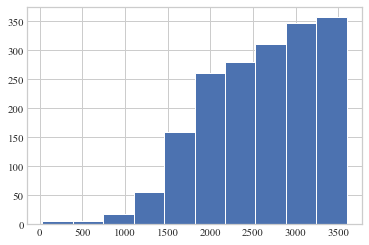

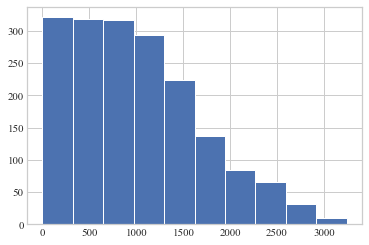

rank sum: 4669678.0 1812122.0
u1, u2  191222.0 3048778.0
u= 3048778.0
z= -45.82171203256596
p= 0.0
O_3
   label     value  rank
0      1  0.000000   1.0
1      1  0.021832  11.0
2      1  0.035771  18.0
3      1  0.049843  30.0
4      1  0.064000  40.0
      label     value    rank
3595      2  0.529687  2044.0
3596      2  0.537457  2105.0
3597      2  0.503650  1801.0
3598      2  0.474226  1552.0
3599      2  0.442052  1300.0


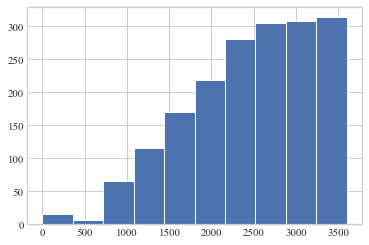

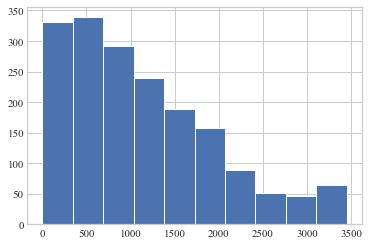

rank sum: 4438158.0 2043642.0
u1, u2  422742.0 2817258.0
u= 2817258.0
z= -38.39673574529134
p= 2.875e-321


In [99]:
for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    for i in range(3):
        print(f"O_{i + 1}")
        key1 = f"{room_num}_{date}_{i + 1:02d}_{1}"
        key2 = f"{room_num}_{date}_04_{i + 1}"
        data1 = list(likelihood_dict[key1].values())
        data2 = list(likelihood_dict[key2].values())
        data = data1 + data2
        
        data1 = (np.array(data1) - np.min(data)) / (np.max(data) - np.min(data))
        data2 = (np.array(data2) - np.min(data)) / (np.max(data) - np.min(data))

        mwu(data1, data2)

In [106]:
for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    for i in range(3):
        key1 = f"{room_num}_{date}_{i + 1:02d}_{1}"
        key2 = f"{room_num}_{date}_04_{i + 1}"
        data1 = np.array(list(likelihood_dict[key1].values()))
        data2 = np.array(list(likelihood_dict[key2].values()))

        w, p = stats.mannwhitneyu(data1, data2, alternative='greater', use_continuity=True)
        print(f"O_{i + 1}")
        print('Mann-Whitney U', f"statistic: {w:e}", f"p: {p:e}")

{'room_num': '02', 'date': '20210903', 'option': 'attention'}
O_1
Mann-Whitney U statistic: 2.821901e+06 p: 0.000000e+00
O_2
Mann-Whitney U statistic: 3.146166e+06 p: 0.000000e+00
O_3
Mann-Whitney U statistic: 2.496487e+06 p: 3.758162e-174
{'room_num': '08', 'date': '20210915', 'option': 'attention'}
O_1
Mann-Whitney U statistic: 3.265684e+06 p: 0.000000e+00
O_2
Mann-Whitney U statistic: 3.024440e+06 p: 0.000000e+00
O_3
Mann-Whitney U statistic: 3.325832e+06 p: 0.000000e+00
{'room_num': '09', 'date': '20210706', 'option': 'attention'}
O_1
Mann-Whitney U statistic: 3.229495e+06 p: 0.000000e+00
O_2
Mann-Whitney U statistic: 3.048778e+06 p: 0.000000e+00
O_3
Mann-Whitney U statistic: 2.817258e+06 p: 0.000000e+00
